多模式多波长光场调制系统 - 训练-仿真集成版
配置完成，使用设备: cuda

阶段1: 数据准备
创建数据生成器...
生成标签...
可视化标签布局...


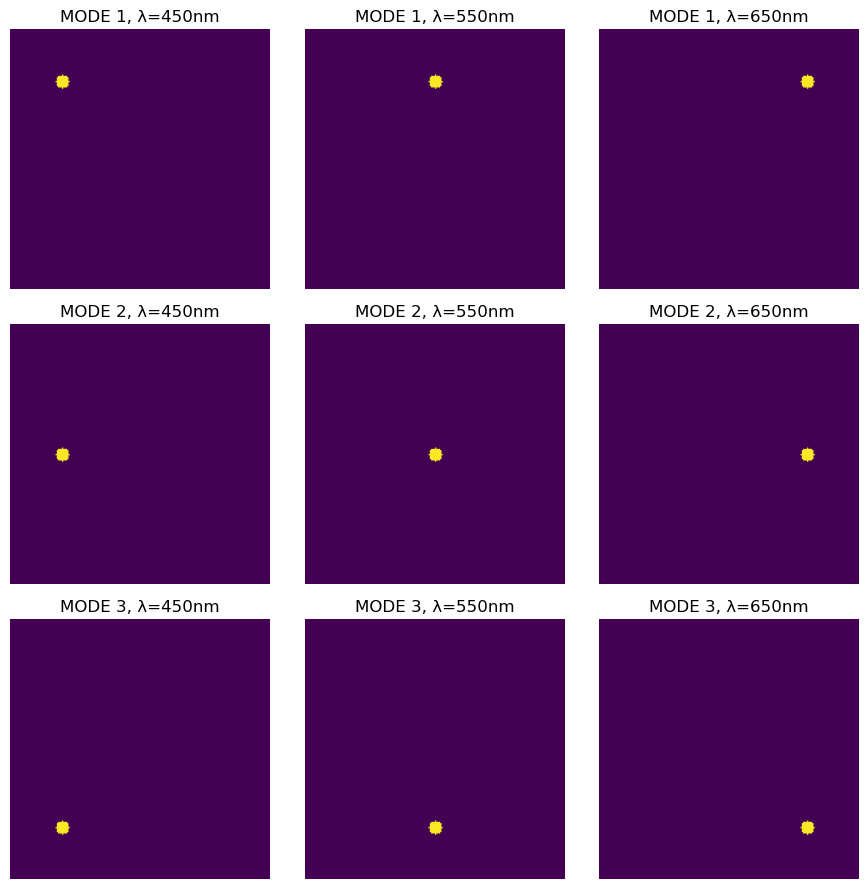

创建评估区域...


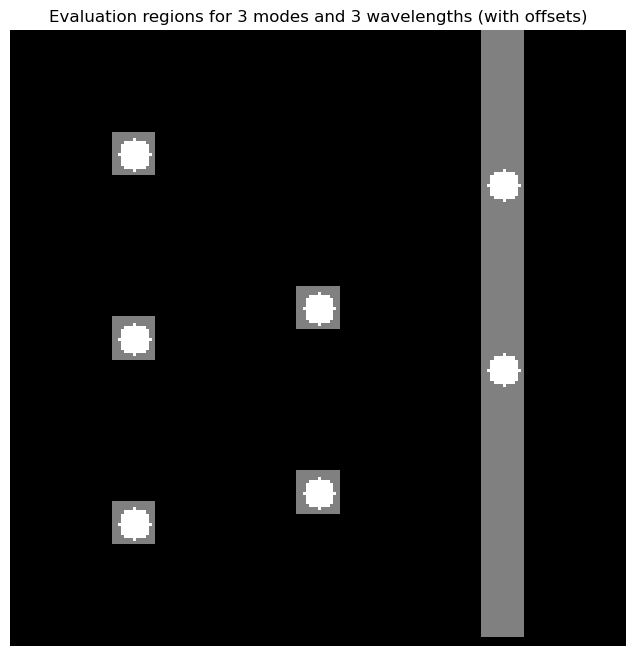

✓ 数据准备完成

阶段2: 模型训练
开始训练新模型...
使用外部提供的评估区域: 9个区域

开始训练 1 层模型...
原始数据形状: (50, 50, 55)
选择后的数据形状: (3, 50, 50)
模式 1 振幅范围: 0.0 - 0.10288702696561813
模式 2 振幅范围: 0.0 - 0.0885566994547844
模式 3 振幅范围: 0.0 - 0.0885566994547844
计算波长系数 (基准波长: 650.0nm)
  波长 450.0nm: 系数 = 1.4444
  波长 550.0nm: 系数 = 1.1818
  波长 650.0nm: 系数 = 1.0000


/home/shiyue/ODNN/ODNN_WAVE/light_propagation_simulation_qz.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  E = torch.tensor(E, dtype=torch.complex64, device=device)
/home/shiyue/miniconda3/envs/ODNN/lib/python3.12/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/libtorch_1745854776362/work/aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


开始训练 - 设备: cuda:0
训练参数: epochs=500, lr=0.01
Epoch [0/500], Loss: 0.002077438868582249
Epoch [100/500], Loss: 0.001901796786114573
Epoch [200/500], Loss: 0.001841288991272449
Epoch [300/500], Loss: 0.001825873856432736
Epoch [400/500], Loss: 0.001820832374505699
✓ 训练完成!
计算可见度: 3波长, 3批次, 9区域, 3模式
处理波长 450nm (索引0)
  处理模式 1
    批次0: 能量=[np.float32(7.169575), np.float32(0.8243609), np.float32(5.0072002)], 可见度=0.793753
  模式1平均可见度: 0.786291
  处理模式 2
    批次0: 能量=[np.float32(8.821787), np.float32(2.153368), np.float32(0.31235576)], 可见度=0.931607
  模式2平均可见度: 0.937403
  处理模式 3
    批次0: 能量=[np.float32(8.633968), np.float32(0.0), np.float32(0.546495)], 可见度=1.000000
  模式3平均可见度: 1.000000
处理波长 550nm (索引1)
  处理模式 1
    批次0: 能量=[np.float32(0.3264253), np.float32(1.3114787), np.float32(6.3988914)], 可见度=0.902926
  模式1平均可见度: 0.912808
  处理模式 2
    批次0: 能量=[np.float32(0.83127105), np.float32(0.42614684), np.float32(0.626595)], 可见度=0.322187
  模式2平均可见度: 0.591091
  处理模式 3
    批次0: 能量=[np.float32(0.47332516), np.

KeyboardInterrupt: 

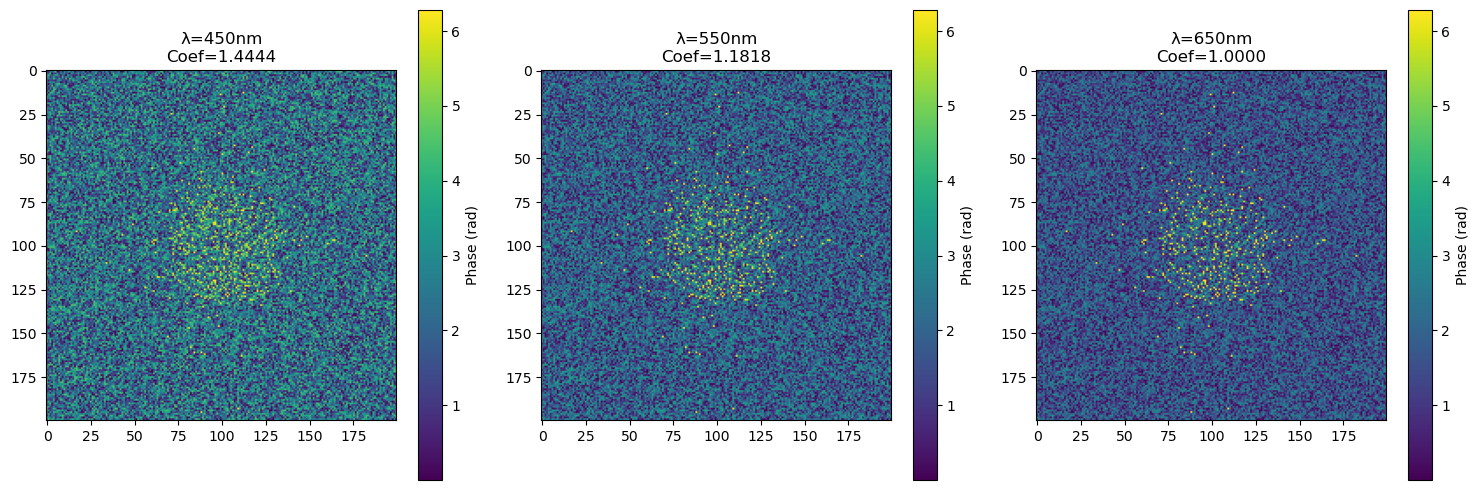

In [ ]:
# -*- coding: utf-8 -*-
"""
多模式多波长光场调制系统 - 主程序（修改版）
集成训练-仿真工作流程 - 无需额外模块版本
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from datetime import datetime

# 导入自定义模块
from label_utils import create_evaluation_regions_mode_wavelength, evaluate_output, evaluate_all_regions, visualize_labels
from config import Config
from data_generator import MultiModeMultiWavelengthDataGenerator
from visualizer import Visualizer
from trainer import Trainer
from model import MultiModeMultiWavelengthModel
from simulator import Simulator
def visualize_labels_grid(labels, wavelengths, save_path=None):
    """
    可视化多模式多波长标签，布局与evaluation regions一致
    
    参数:
        labels: shape (num_modes, num_wavelengths, H, W)
        wavelengths: 波长列表
        save_path: 保存路径
    """
    # 转换为numpy数组以便处理
    if torch.is_tensor(labels):
        labels_np = labels.detach().cpu().numpy()
    else:
        labels_np = labels
    
    num_modes, num_wavelengths, H, W = labels_np.shape
    
    # 创建子图 - 3行3列（模式×波长）
    fig, axes = plt.subplots(num_modes, num_wavelengths, 
                            figsize=(num_wavelengths*3, num_modes*3))
    
    # 确保axes是2D数组
    if num_modes == 1:
        axes = axes.reshape(1, -1)
    if num_wavelengths == 1:
        axes = axes.reshape(-1, 1)
    
    # 按照evaluation regions的布局显示
    for mode_idx in range(num_modes):
        for wl_idx in range(num_wavelengths):
            ax = axes[mode_idx, wl_idx]
            
            # 显示标签
            label = labels_np[mode_idx, wl_idx]
            im = ax.imshow(label, cmap='viridis', vmin=0, vmax=1)
            
            # 设置标题 - 与evaluation regions对应
            wl_nm = wavelengths[wl_idx] * 1e9  # 转换为纳米
            ax.set_title(f'MODE {mode_idx+1}, λ={wl_nm:.0f}nm', 
                        fontsize=10)
            ax.axis('off')
            
            # 添加颜色条
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ 修正后的标签布局已保存到: {save_path}")
    
    plt.show()


def verify_layout_consistency(config, labels, evaluation_regions):
    """验证evaluation regions和标签布局的一致性"""
    
    print("🔍 验证布局一致性...")
    print("="*50)
    
    # 转换labels为numpy数组
    if torch.is_tensor(labels):
        labels_np = labels.detach().cpu().numpy()
    else:
        labels_np = labels
    
    print(f"标签形状: {labels_np.shape}")
    print(f"Evaluation regions数量: {len(evaluation_regions)}")
    print()
    
    # 检查每个位置的对应关系
    region_idx = 0
    max_deviation_x = 0
    max_deviation_y = 0
    
    for mode_idx in range(config.num_modes):
        for wl_idx in range(len(config.wavelengths)):
            # 获取标签中心
            label = labels_np[mode_idx, wl_idx]
            y_indices, x_indices = np.where(label > 0.5)
            if len(x_indices) > 0:
                label_center_x = np.mean(x_indices)
                label_center_y = np.mean(y_indices)
            else:
                label_center_x, label_center_y = 0, 0
            
            # 获取evaluation region中心
            x_start, x_end, y_start, y_end = evaluation_regions[region_idx]
            region_center_x = (x_start + x_end) / 2
            region_center_y = (y_start + y_end) / 2
            
            # 计算偏差
            deviation_x = abs(label_center_x - region_center_x)
            deviation_y = abs(label_center_y - region_center_y)
            max_deviation_x = max(max_deviation_x, deviation_x)
            max_deviation_y = max(max_deviation_y, deviation_y)
            
            wl_nm = config.wavelengths[wl_idx] * 1e9
            print(f"模式{mode_idx+1}, 波长{wl_nm:.0f}nm:")
            print(f"  标签中心: ({label_center_x:.1f}, {label_center_y:.1f})")
            print(f"  区域中心: ({region_center_x:.1f}, {region_center_y:.1f})")
            print(f"  偏差: ({deviation_x:.1f}, {deviation_y:.1f})")
            print()
            
            region_idx += 1
    
    # 判断布局是否一致
    threshold = 5.0  # 像素偏差阈值
    if max_deviation_x < threshold and max_deviation_y < threshold:
        print(f"✅ 布局验证通过！最大偏差: ({max_deviation_x:.1f}, {max_deviation_y:.1f}) < {threshold}")
    else:
        print(f"❌ 布局存在偏差！最大偏差: ({max_deviation_x:.1f}, {max_deviation_y:.1f}) >= {threshold}")
        print("建议检查标签生成或evaluation regions创建逻辑")
    
    # 使用修正后的可视化函数
    save_path = os.path.join(config.save_dir, "corrected_labels_layout.png")
    visualize_labels_grid(
        labels, 
        config.wavelengths,
        save_path=save_path
    )
    
    print("="*50)
# 记录开始时间
start_time = time.time()

# 设置随机种子，确保结果可重现
torch.manual_seed(42)
np.random.seed(42)

print("=" * 60)
print("多模式多波长光场调制系统 - 训练-仿真集成版")
print("=" * 60)

# ===== 掩码加载器类（内联定义）=====
class SimpleMaskLoader:
    """简化的相位掩码加载器"""
    
    def __init__(self, config):
        self.config = config
    
    def create_fallback_masks(self, num_layers=3):
        """创建备用聚焦掩码"""
        print("⚠ 创建备用聚焦掩码...")
        
        def create_focusing_mask(size, wavelength, focal_length, pixel_size):
            center = size // 2
            y, x = np.ogrid[:size, :size]
            r_squared = ((x - center) * pixel_size) ** 2 + ((y - center) * pixel_size) ** 2
            k = 2 * np.pi / wavelength
            phase = -k * r_squared / (2 * focal_length)
            return np.mod(phase, 2 * np.pi)
        
        masks = []
        focal_lengths = [50e-3, 100e-3, 150e-3]  # 不同层的焦距
        
        for layer_idx in range(num_layers):
            layer_masks = []
            for wl_idx, wavelength in enumerate(self.config.wavelengths):
                focal_length = focal_lengths[layer_idx % len(focal_lengths)]
                mask = create_focusing_mask(
                    self.config.layer_size, wavelength, focal_length, self.config.pixel_size
                )
                layer_masks.append(mask)
            masks.append(layer_masks)
        
        print(f"✓ 创建了 {len(masks)} 层备用掩码")
        return masks
    
    def get_masks_for_simulation(self, trained_masks=None, num_layers=3):
        """获取用于仿真的掩码"""
        if trained_masks is not None:
            print("✓ 使用训练好的相位掩码进行仿真")
            return trained_masks
        else:
            print("⚠ 使用备用掩码进行仿真")
            return self.create_fallback_masks(num_layers)

# 创建配置
config = Config(
    # 基本参数
    num_modes=3,                                # 模式数量
    wavelengths=np.array([450e-9, 550e-9, 650e-9]),  # 波长列表(m)
    
    # 空间参数
    field_size=50,                              # 场大小(像素)
    layer_size=200,                             # 层大小(像素)
    focus_radius=5,                             # 焦点半径(像素)
    detectsize=15,                              # 检测区域大小(像素)
    
    # 物理参数
    z_layers=40e-6,                             # 层间距离(m)
    z_prop=300e-6,                              # 传播距离(m)
    z_step=20e-6,                               # 传播步长(m)
    pixel_size=1e-6,                            # 像素大小(m)
    
    # 检测区域偏移 - 为每个波长定义不同的偏移
    offsets=[(0,0), (50,0), (-50,0)],           # 每个波长的检测区域偏移
    
    # 训练参数
    learning_rate=0.01,                         # 学习率
    lr_decay=0.99,                              # 学习率衰减
    epochs=500,                                 # 训练轮数
    batch_size=16,                               # 批量大小
    
    # 保存参数
    save_dir="./results_multi_mode_multi_wl/",  # 保存目录
    flag_savemat=True                           # 是否保存.mat文件
)

# 确保保存目录存在
os.makedirs(config.save_dir, exist_ok=True)
os.makedirs(os.path.join(config.save_dir, "trained_models"), exist_ok=True)

# ===== 阶段1: 数据准备 =====
print("\n" + "="*50)
print("阶段1: 数据准备")
print("="*50)

# 创建数据生成器
print("创建数据生成器...")
data_generator = MultiModeMultiWavelengthDataGenerator(config)

# 生成多模式多波长标签
print("生成标签...")
labels = data_generator.generate_labels()

# 可视化标签布局
print("可视化标签布局...")
visualize_labels(labels, config.wavelengths)

# 创建评估区域
print("创建评估区域...")
# 在您的主程序中，创建evaluation_regions时也要传入偏移
evaluation_regions = create_evaluation_regions_mode_wavelength(
    config.layer_size, 
    config.layer_size, 
    config.focus_radius, 
    detectsize=config.detectsize,
    offsets=config.offsets  # ← 添加偏移参数
)

# 🆕 添加布局验证
print("验证标签与评估区域布局一致性...")
verify_layout_consistency(config, labels, evaluation_regions)


print("✓ 数据准备完成")

# ===== 阶段2: 模型训练 =====
print("\n" + "="*50)
print("阶段2: 模型训练")
print("="*50)

# 检查是否存在已训练的模型
trained_models_dir = os.path.join(config.save_dir, "trained_models")
existing_models = []
if os.path.exists(trained_models_dir):
    model_files = [f for f in os.listdir(trained_models_dir) if f.startswith("model_") and f.endswith("layers.pth")]
    existing_models = [f for f in model_files]

# 定义要训练的层数选项
num_layer_options = [1, 2, 3, 4, 5]  # 可以根据需要调整层数

# 询问是否使用现有模型或重新训练
use_existing = False
if existing_models:
    print(f"发现已存在的训练模型: {existing_models}")
    try:
        response = input("是否使用现有模型？(y/n，默认n): ").lower().strip()
        use_existing = response == 'y'
    except:
        print("使用默认选项：重新训练")
        use_existing = False

if use_existing and existing_models:
    print("加载现有训练模型...")
    results = {'models': [], 'losses': [], 'phase_masks': [], 'weights_pred': [], 'visibility': []}
    
    for num_layers in num_layer_options:
        model_path = os.path.join(trained_models_dir, f"model_{num_layers}layers.pth")
        if os.path.exists(model_path):
            print(f"加载 {num_layers} 层模型...")
            
            try:
                # 加载模型检查点
                checkpoint = torch.load(model_path, map_location='cpu')
                
                # 创建模型实例
                model = MultiModeMultiWavelengthModel(config, num_layers)
                model.load_state_dict(checkpoint['model_state_dict'])
                
                # 提取相位掩码
                phase_masks = []
                if hasattr(model, 'get_phase_masks_for_simulation'):
                    phase_masks = model.get_phase_masks_for_simulation()
                else:
                    # 兼容旧版本
                    for layer in model.layers:
                        phase = layer.phase.detach().cpu().numpy()
                        phase = phase % (2 * np.pi)
                        wavelength_masks = []
                        for _ in range(len(config.wavelengths)):
                            wavelength_masks.append(phase)
                        phase_masks.append(wavelength_masks)
                
                # 获取训练损失和可见度
                losses = checkpoint.get('train_losses', [])
                weights_pred = checkpoint.get('weights_pred', [])
                visibility = checkpoint.get('visibility', [])

                
                results['models'].append(model)
                results['losses'].append(losses)
                results['phase_masks'].append(phase_masks)
                results['weights_pred'].append(weights_pred)
                results['visibility'].append(visibility)
                
                
                print(f"✓ 成功加载 {num_layers} 层模型")
                
            except Exception as e:
                print(f"✗ 加载 {num_layers} 层模型失败: {e}")
                # 添加空结果以保持索引一致
                results['models'].append(None)
                results['losses'].append([])
                results['phase_masks'].append([])
                results['weights_pred'].append([])
                results['visibility'].append([])
        else:
            print(f"✗ 未找到 {num_layers} 层模型文件")
            # 添加空结果以保持索引一致
            results['models'].append(None)
            results['losses'].append([])
            results['phase_masks'].append([])
            results['weights_pred'].append([])
            results['visibility'].append([])
else:
    print("开始训练新模型...")
    
    # 创建训练器
    trainer = Trainer(config, data_generator, MultiModeMultiWavelengthModel, evaluation_regions=evaluation_regions)
    
    # 训练多个层数的模型
    results = trainer.train_multiple_models(num_layer_options)

print("✓ 模型准备完成")

# ===== 阶段3: 结果分析 =====
print("\n" + "="*50)
print("阶段3: 结果分析")
print("="*50)

# 检查可见度数据结构
print("检查训练结果...")
print(f"results键: {list(results.keys())}")
print(f"可见度数据结构: {len(results['visibility'])}层")

valid_results = []
for i, vis_data in enumerate(results['visibility']):
    if vis_data:  # 只处理非空的可见度数据
        expected_length = len(config.wavelengths) * config.num_modes
        print(f"第{i+1}层 ({num_layer_options[i]}层模型):")
        print(f"  数据长度: {len(vis_data)}")
        print(f"  期望长度: {expected_length} ({len(config.wavelengths)}波长 × {config.num_modes}模式)")
        
        if len(vis_data) == expected_length:
            print(f"  ✅ 数据长度匹配！")
            valid_results.append(i)
            # 按波长和模式重新组织显示
            vis_array = np.array(vis_data).reshape(len(config.wavelengths), config.num_modes)
            for wl_idx, wl in enumerate(config.wavelengths):
                wl_nm = wl * 1e9
                print(f"    {wl_nm:.0f}nm: MODE1={vis_array[wl_idx, 0]:.6f}, MODE2={vis_array[wl_idx, 1]:.6f}, MODE3={vis_array[wl_idx, 2]:.6f}")
        else:
            print(f"  ❌ 数据长度不匹配！")
    else:
        print(f"第{i+1}层 ({num_layer_options[i]}层模型): 无可见度数据")

# 可视化训练损失
if results['losses'] and any(results['losses']):
    print("可视化训练损失...")
    plt.figure(figsize=(10, 6))
    for i, num_layers in enumerate(num_layer_options):
        if results['losses'][i]:  # 确保有损失数据
            plt.plot(results['losses'][i], label=f'{num_layers} Layer(s)')
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.title('Losses through layers')
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{config.save_dir}/training_losses.png", dpi=300)
    plt.show()


In [ ]:
# ===== 阶段4: 光场传播仿真 =====
import glob

print("\n" + "="*50)
print("阶段4: 光场传播仿真")
print("="*50)

# 创建掩码加载器
mask_loader = SimpleMaskLoader(config)

# 创建仿真器
simulator = Simulator(config, evaluation_regions=evaluation_regions)

run_simulation = True

if run_simulation:
    print("开始光场传播仿真...")
    
    # **关键修复：只生成一次输入场，供所有模型使用**
    print("生成多模式输入场...")
    input_fields = data_generator.generate_input_data()
    print(f"✓ 生成输入场完成，形状: {input_fields.shape}")
    print(f"  模式数: {input_fields.shape[0]}")
    print(f"  波长数: {input_fields.shape[1]}")
    print(f"  空间尺寸: {input_fields.shape[2]}×{input_fields.shape[3]}")
    
    # 选择要仿真的模型
    simulation_results = {}
    
    for i, num_layers in enumerate(num_layer_options):
        if i < len(results['models']) and results['models'][i] is not None:
            print(f"\n{'='*60}")
            print(f"仿真 {num_layers} 层模型 ({i+1}/{len(num_layer_options)})")
            print(f"{'='*60}")
            
            try:
                # 获取训练好的相位掩码
                if i < len(results['phase_masks']) and results['phase_masks'][i]:
                    phase_masks = results['phase_masks'][i]
                    print(f"✓ 使用训练好的 {num_layers} 层相位掩码")
                    print(f"  掩码层数: {len(phase_masks)}")
                    print(f"  每层波长数: {len(phase_masks[0]) if phase_masks else 0}")
                else:
                    # 使用备用掩码
                    phase_masks = mask_loader.get_masks_for_simulation(None, num_layers)
                    print(f"⚠ 使用备用 {num_layers} 层相位掩码")
                
                # 执行仿真
                print("执行光场传播...")
                propagation_results = simulator.simulate_propagation(
                    phase_masks=phase_masks,
                    input_field=input_fields,  # 使用同一个输入场
                    process_all_modes=True
                )
                
                # 验证仿真结果
                print(f"仿真结果验证:")
                print(f"  结果数量: {len(propagation_results) if propagation_results else 0}")
                
                if propagation_results:
                    # 按模式统计结果
                    mode_counts = {}
                    for result in propagation_results:
                        if isinstance(result, dict):
                            mode_idx = result.get('mode_idx', 0)
                            mode_counts[mode_idx] = mode_counts.get(mode_idx, 0) + 1
                    
                    print(f"  模式分布: {mode_counts}")
                    
                    # 显示前几个结果的详细信息 - 修复：使用一致的显示标签
                    for idx, result in enumerate(propagation_results[:6]):  # 显示前6个结果
                        if isinstance(result, dict):
                            mode_idx = result.get('mode_idx', 0)  # 内部索引 0-2
                            wl_idx = result.get('wavelength_idx', 0)
                            focus_ratio = result.get('focus_ratio', 0)
                            peak_intensity = result.get('peak_intensity', 0)
                            
                            wl_nm = config.wavelengths[wl_idx] * 1e9 if wl_idx < len(config.wavelengths) else 0
                            # 修复：显示标签使用 mode_idx+1，保持与图表一致
                            display_mode = mode_idx + 1  # 转换为显示标签 1-3
                            print(f"    结果{idx+1}: 模式{display_mode}, {wl_nm:.0f}nm, 聚焦比例={focus_ratio:.4f}, 峰值={peak_intensity:.6f}")
                
                # 保存仿真结果
                simulation_results[num_layers] = propagation_results
                
                print(f"✅ {num_layers} 层模型仿真完成")
                
            except Exception as e:
                print(f"❌ {num_layers} 层模型仿真失败: {e}")
                import traceback
                traceback.print_exc()
                continue
    
    # 验证所有仿真结果
    print(f"\n{'='*50}")
    print("仿真结果总览")
    print(f"{'='*50}")
    
    total_results = 0
    for num_layers, results_list in simulation_results.items():
        count = len(results_list) if results_list else 0
        total_results += count
        print(f"{num_layers}层模型: {count}个结果")
    
    print(f"总计: {total_results}个仿真结果")
    print(f"期望: {len(num_layer_options) * config.num_modes * len(config.wavelengths)}个结果")
    
    print("✓ 光场传播仿真完成")

# ===== 新增：阶段4.5: 仿真结果可视化分析 =====
print("\n" + "="*50)
print("阶段4.5: 仿真结果可视化分析")
print("="*50)

try:
    if run_simulation and simulation_results:
        print("开始创建仿真结果可视化...")
        
        # 1. 创建传播结果总结图（为每个层数模型）
        print("\n1. 创建传播结果总结图...")
        simulator.create_propagation_summary(config.save_dir)
        
        # 2. 创建详细分析报告
        print("\n2. 创建详细分析报告...")
        simulator.create_detailed_analysis(config.save_dir)
        
        # 3. 创建性能对比图
        print("\n3. 创建性能对比图...")
        simulator.create_performance_comparison(config.save_dir)
        
        # **新增：4. 基于仿真结果重新计算并可视化 visibility**
        print("\n4. 基于仿真结果计算真实 visibility...")
        visualizer = Visualizer(config)
        
        # 从仿真结果计算真实 visibility
        real_visibility_data = visualizer.calculate_visibility_from_simulation_results(
            config.save_dir, config, num_layer_options
        )
        
        if real_visibility_data:
            # 创建基于真实仿真结果的 visibility 分析图
            print("创建真实 visibility 分析图...")
            visualizer.create_detailed_visibility_analysis(
                real_visibility_data, config, num_layer_options, 
                save_path=os.path.join(config.save_dir, 'real_visibility_analysis.png'),
                title_suffix="(基于仿真结果)"
            )
            
            # 对比原始 visibility 和真实 visibility（如果有原始数据）
            if valid_results and 'visibility' in results and results['visibility']:
                print("创建 visibility 对比分析...")
                
                # 组织原始 visibility 数据
                original_visibility = visualizer.organize_visibility_by_mode(
                    results, config, num_layer_options
                )
                
                # 创建对比图
                visualizer.create_visibility_comparison(
                    original_visibility=original_visibility,
                    real_visibility=real_visibility_data,
                    config=config,
                    num_layer_options=num_layer_options,
                    save_path=os.path.join(config.save_dir, 'visibility_comparison.png')
                )
                
                print("✅ Visibility 对比分析完成")
            else:
                print("⚠ 没有原始 visibility 数据，跳过对比分析")
            
            # 创建综合分析报告
            print("创建综合 visibility 分析报告...")
            visualizer.create_comprehensive_visibility_report(
                real_visibility_data, config, num_layer_options, config.save_dir
            )
            
        else:
            print("❌ 无法从仿真结果计算 visibility")
        
        # 5. 为每个模式创建可视化（可选）- 修复：使用正确的显示标签
        print("\n5. 创建各模式传播结果可视化...")
        for mode_idx in range(config.num_modes):
            display_mode = mode_idx + 1  # 转换为显示标签
            mode_suffix = f"_mode{display_mode}"  # 使用显示标签命名
            simulator.visualize_propagation_results(config.save_dir, mode_suffix)
        
        print("\n✅ 仿真结果可视化完成")
        
        # 生成最终总结报告
        print(f"\n{'='*60}")
        print("🎯 仿真分析总结")
        print(f"{'='*60}")
        
        print(f"✅ 仿真完成的模型: {len(simulation_results)}/{len(num_layer_options)}")
        
        # 统计生成的文件
        npy_files = glob.glob(os.path.join(config.save_dir, 'MC_single_*.npy'))
        png_files = glob.glob(os.path.join(config.save_dir, '*.png'))
        json_files = glob.glob(os.path.join(config.save_dir, '*.json'))
        csv_files = glob.glob(os.path.join(config.save_dir, '*.csv'))
        
        print(f"✅ 生成的仿真数据文件: {len(npy_files)}")
        print(f"✅ 生成的可视化图表: {len(png_files)}")
        print(f"✅ 生成的数据分析文件: {len(json_files)} JSON, {len(csv_files)} CSV")
        
        print(f"\n📊 生成的主要图表文件:")
        key_images = [
            'real_visibility_analysis.png',
            'visibility_comparison.png', 
            'detailed_visibility_analysis.png',
            'mode_wavelength_matrix.png',
            'visibility_statistics_visualization.png',
            'performance_comparison.png'
        ]
        
        for img_file in key_images:
            img_path = os.path.join(config.save_dir, img_file)
            if os.path.exists(img_path):
                print(f"  ✅ {img_file}")
            else:
                print(f"  ❌ {img_file} (未生成)")
        
        print(f"\n📁 所有结果保存在: {config.save_dir}")
        
        # 检查是否有分析报告
        report_files = [
            'detailed_analysis_report.txt',
            'detailed_analysis_data.json',
            'visibility_statistics.json',
            'visibility_data.csv',
            'analysis_summary.json'
        ]
        
        print(f"\n📋 分析报告:")
        for report_file in report_files:
            report_path = os.path.join(config.save_dir, report_file)
            if os.path.exists(report_path):
                print(f"  ✅ {report_file}")
            else:
                print(f"  ❌ {report_file} (未生成)")
        
        # 运行完整分析流程（这是一个综合方法）
        print(f"\n{'='*50}")
        print("运行完整分析流程...")
        print(f"{'='*50}")
        simulator.run_complete_analysis(config.save_dir)
        
        # **新增：创建最终的综合报告**
        print(f"\n{'='*50}")
        print("创建最终综合分析报告...")
        print(f"{'='*50}")
        
        try:
            # 如果有真实 visibility 数据，创建完整的分析报告
            if real_visibility_data:
                visualizer.create_complete_analysis_report(
                    results={'visibility': real_visibility_data}, 
                    config=config, 
                    num_layer_options=num_layer_options, 
                    save_dir=config.save_dir
                )
                print("✅ 综合分析报告创建完成")
            
            # 创建性能总结 - 修复：使用一致的显示标签
            print("\n📈 性能分析总结:")
            if real_visibility_data:
                all_values = []
                best_configs = []
                
                for mode_idx, mode_data in enumerate(real_visibility_data):
                    mode_array = np.array(mode_data)
                    all_values.extend(mode_array.flatten())
                    
                    # 找到每个模式的最佳配置
                    if mode_array.size > 0:
                        best_pos = np.unravel_index(np.argmax(mode_array), mode_array.shape)
                        best_layer = num_layer_options[best_pos[0]]
                        best_wl = config.wavelengths[best_pos[1]] * 1e9
                        best_vis = mode_array[best_pos]
                        
                        display_mode = mode_idx + 1  # 转换为显示标签
                        best_configs.append({
                            'mode': display_mode,  # 使用显示标签
                            'layers': best_layer,
                            'wavelength': int(best_wl),
                            'visibility': best_vis
                        })
                        
                        # 修复：显示时使用一致的标签
                        print(f"  模式 {display_mode}: {best_layer}层@{int(best_wl)}nm, visibility={best_vis:.4f}")
                
                if all_values:
                    overall_max = np.max(all_values)
                    overall_avg = np.mean(all_values)
                    
                    print(f"\n🏆 整体性能:")
                    print(f"  最大 visibility: {overall_max:.4f}")
                    print(f"  平均 visibility: {overall_avg:.4f}")
                    print(f"  有效配置数: {np.sum(np.array(all_values) > 0.01)}/{len(all_values)}")
                
        except Exception as e:
            print(f"❌ 创建综合分析报告失败: {e}")
            import traceback
            traceback.print_exc()
        
except Exception as e:
    print(f"❌ 仿真结果可视化失败: {e}")
    import traceback
    traceback.print_exc()

print("\n🎉 仿真和可视化分析完成！")

# ===== 阶段5: 模型与仿真对比分析 =====
print("\n" + "="*50)
print("阶段5: 模型与仿真对比分析")
print("="*50)

if run_simulation and simulation_results and valid_results:
    print("开始模型预测与仿真结果对比...")
    
    try:
        # 创建对比分析
        comparison_results = {}
        
        for i, num_layers in enumerate(num_layer_options):
            if (i in valid_results and 
                num_layers in simulation_results and 
                i < len(results['weights_pred']) and 
                results['weights_pred'][i] is not None):
                
                print(f"\n{'='*40}")
                print(f"分析 {num_layers} 层模型")
                print(f"{'='*40}")
                
                # 获取模型预测结果 - 修复numpy数组判断问题
                model_predictions = results['weights_pred'][i]
                
                # 安全地检查模型预测数据
                if model_predictions is not None:
                    if isinstance(model_predictions, np.ndarray):
                        # 展平多维数组
                        model_predictions_flat = model_predictions.flatten()
                        model_pred_len = len(model_predictions_flat)
                        has_model_pred = model_predictions_flat.size > 0
                        print(f"模型预测原始形状: {model_predictions.shape}")
                        print(f"模型预测展平后长度: {model_pred_len}")
                    else:
                        model_predictions_flat = model_predictions
                        model_pred_len = len(model_predictions) if model_predictions else 0
                        has_model_pred = bool(model_predictions)
                        print(f"模型预测数据长度: {model_pred_len}")
                else:
                    model_predictions_flat = []
                    model_pred_len = 0
                    has_model_pred = False
                    print(f"模型预测数据长度: 0")
                
                # 获取仿真结果
                sim_results = simulation_results[num_layers]
                has_sim_results = bool(sim_results)
                print(f"仿真结果数量: {len(sim_results) if has_sim_results else 0}")
                
                if has_model_pred and has_sim_results:
                    # 重新组织仿真结果以匹配模型预测格式
                    # 期望格式：[mode0_wl0, mode0_wl1, mode0_wl2, mode1_wl0, mode1_wl1, mode1_wl2, ...]
                    
                    # 按模式和波长组织仿真结果
                    organized_sim_results = {}
                    for result in sim_results:
                        if isinstance(result, dict):
                            mode_idx = result.get('mode_idx', 0)  # 内部索引 0-2
                            wl_idx = result.get('wavelength_idx', 0)
                            key = (mode_idx, wl_idx)
                            organized_sim_results[key] = result
                    
                    print(f"组织后的仿真结果键: {sorted(organized_sim_results.keys())}")
                    
                    # 提取对应的检测器响应
                    sim_detector_responses = []
                    expected_keys = []
                    
                    for mode_idx in range(config.num_modes):  # 内部索引 0-2
                        for wl_idx in range(len(config.wavelengths)):
                            key = (mode_idx, wl_idx)
                            expected_keys.append(key)
                            
                            if key in organized_sim_results:
                                result = organized_sim_results[key]
                                # 使用聚焦比例作为主要指标
                                response = result.get('focus_ratio', 0.0)
                                sim_detector_responses.append(response)
                            else:
                                # 修复：显示时使用显示标签，但内部仍使用内部索引
                                display_mode = mode_idx + 1
                                print(f"  ⚠ 缺少模式{display_mode}波长{wl_idx}的仿真结果")
                                sim_detector_responses.append(0.0)
                    
                    print(f"期望的键: {expected_keys}")
                    print(f"仿真响应长度: {len(sim_detector_responses)}")
                    print(f"模型预测长度: {model_pred_len}")
                    
                    # 确保长度匹配 - 处理长度不同的情况
                    min_len = min(model_pred_len, len(sim_detector_responses))
                    
                    if min_len > 1:
                        # 安全地转换为numpy数组并确保是1维的
                        model_array = np.array(model_predictions_flat[:min_len]).flatten()
                        sim_array = np.array(sim_detector_responses[:min_len]).flatten()
                        
                        print(f"  处理后的数组形状:")
                        print(f"    模型预测: {model_array.shape}")
                        print(f"    仿真结果: {sim_array.shape}")
                        
                        # 检查数据有效性
                        if len(model_array) == len(sim_array) and len(model_array) > 1:
                            # 归一化数据以提高相关性计算的稳定性
                            model_std = np.std(model_array)
                            sim_std = np.std(sim_array)
                            
                            print(f"  数据统计:")
                            print(f"    模型预测 - 均值: {np.mean(model_array):.6f}, 标准差: {model_std:.6f}")
                            print(f"    仿真结果 - 均值: {np.mean(sim_array):.6f}, 标准差: {sim_std:.6f}")
                            
                            if model_std > 1e-10 and sim_std > 1e-10:
                                model_norm = (model_array - np.mean(model_array)) / model_std
                                sim_norm = (sim_array - np.mean(sim_array)) / sim_std
                                
                                # 计算相关系数 - 确保输入是1维数组
                                try:
                                    correlation_matrix = np.corrcoef(model_norm, sim_norm)
                                    correlation = correlation_matrix[0, 1]
                                    
                                    # 检查相关系数是否有效
                                    if np.isnan(correlation):
                                        correlation = 0.0
                                        print(f"  ⚠ 相关系数为NaN，设置为0")
                                    
                                except Exception as corr_e:
                                    print(f"  ⚠ 计算相关系数失败: {corr_e}")
                                    correlation = 0.0
                                
                                # 计算RMSE（使用原始数据）
                                rmse = np.sqrt(np.mean((model_array - sim_array)**2))
                                
                                # 计算平均绝对误差
                                mae = np.mean(np.abs(model_array - sim_array))
                                
                                comparison_results[num_layers] = {
                                    'correlation': float(correlation),
                                    'rmse': float(rmse),
                                    'mae': float(mae),
                                    'model_predictions': model_predictions_flat.tolist() if isinstance(model_predictions_flat, np.ndarray) else model_predictions_flat,
                                    'simulation_results': sim_detector_responses,
                                    'data_length': min_len
                                }
                                
                                print(f"  ✅ 分析完成:")
                                print(f"    数据长度: {min_len}")
                                print(f"    相关系数: {correlation:.4f}")
                                print(f"    RMSE: {rmse:.4f}")
                                print(f"    MAE: {mae:.4f}")
                                print(f"    模型预测范围: [{np.min(model_array):.4f}, {np.max(model_array):.4f}]")
                                print(f"    仿真结果范围: [{np.min(sim_array):.4f}, {np.max(sim_array):.4f}]")
                            else:
                                print(f"  ⚠ 数据标准差过小，无法计算相关性")
                                print(f"    模型标准差: {model_std}")
                                print(f"    仿真标准差: {sim_std}")
                        else:
                            print(f"  ⚠ 数组长度不匹配或长度不足")
                            print(f"    模型数组长度: {len(model_array)}")
                            print(f"    仿真数组长度: {len(sim_array)}")
                    else:
                        print(f"  ⚠ 数据长度不足 (min_len={min_len})，无法计算相关性")
                else:
                    print(f"  ⚠ 缺少有效的预测或仿真数据")
                    print(f"    模型预测有效: {has_model_pred}")
                    print(f"    仿真结果有效: {has_sim_results}")
        
        # 可视化对比结果
        if comparison_results:
            print(f"\n可视化模型-仿真对比结果...")
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            
            layers_list = sorted(comparison_results.keys())
            correlations = [comparison_results[l]['correlation'] for l in layers_list]
            rmses = [comparison_results[l]['rmse'] for l in layers_list]
            maes = [comparison_results[l]['mae'] for l in layers_list]
            
            # 相关系数图
            ax1 = axes[0, 0]
            bars1 = ax1.bar(range(len(layers_list)), correlations, alpha=0.7, color='skyblue')
            ax1.set_xlabel('层数')
            ax1.set_ylabel('相关系数')
            ax1.set_title('模型预测与仿真结果相关性')
            ax1.set_xticks(range(len(layers_list)))
            ax1.set_xticklabels([f'{l}层' for l in layers_list])
            ax1.grid(True, alpha=0.3)
            ax1.set_ylim(-1, 1)
            ax1.axhline(y=0, color='red', linestyle='--', alpha=0.5)
            
            # 添加数值标签
            for i, (bar, v) in enumerate(zip(bars1, correlations)):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02 if height >= 0 else height - 0.05,
                        f'{v:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
            
            # RMSE图
            ax2 = axes[0, 1]
            bars2 = ax2.bar(range(len(layers_list)), rmses, alpha=0.7, color='lightcoral')
            ax2.set_xlabel('层数')
            ax2.set_ylabel('RMSE')
            ax2.set_title('模型预测与仿真结果RMSE')
            ax2.set_xticks(range(len(layers_list)))
            ax2.set_xticklabels([f'{l}层' for l in layers_list])
            ax2.grid(True, alpha=0.3)
            
            # 添加数值标签
            for i, (bar, v) in enumerate(zip(bars2, rmses)):
                height = bar.get_height()
                if rmses:  # 防止除零错误
                    ax2.text(bar.get_x() + bar.get_width()/2., height + max(rmses)*0.01,
                            f'{v:.3f}', ha='center', va='bottom')
            
            # MAE图
            ax3 = axes[1, 0]
            bars3 = ax3.bar(range(len(layers_list)), maes, alpha=0.7, color='lightgreen')
            ax3.set_xlabel('层数')
            ax3.set_ylabel('MAE')
            ax3.set_title('模型预测与仿真结果MAE')
            ax3.set_xticks(range(len(layers_list)))
            ax3.set_xticklabels([f'{l}层' for l in layers_list])
            ax3.grid(True, alpha=0.3)
            
            # 添加数值标签
            for i, (bar, v) in enumerate(zip(bars3, maes)):
                height = bar.get_height()
                if maes:  # 防止除零错误
                    ax3.text(bar.get_x() + bar.get_width()/2., height + max(maes)*0.01,
                            f'{v:.3f}', ha='center', va='bottom')
            
            # 散点图：选择最佳相关性的模型
            ax4 = axes[1, 1]
            if correlations:
                best_idx = np.argmax(np.abs(correlations))  # 选择绝对值最大的相关系数
                best_layer = layers_list[best_idx]
                
                model_pred = comparison_results[best_layer]['model_predictions']
                sim_results_data = comparison_results[best_layer]['simulation_results']
                
                min_len = min(len(model_pred), len(sim_results_data))
                model_array = np.array(model_pred[:min_len])
                sim_array = np.array(sim_results_data[:min_len])
                
                ax4.scatter(model_array, sim_array, alpha=0.7, s=50)
                # 计算理想匹配线的范围
                all_values = np.concatenate([model_array, sim_array])
                min_val, max_val = np.min(all_values), np.max(all_values)
                ax4.plot([min_val, max_val], [min_val, max_val], 
                        'r--', alpha=0.8, label='理想匹配线')
                
                ax4.set_xlabel('模型预测值')
                ax4.set_ylabel('仿真结果值')
                ax4.set_title(f'最佳匹配模型散点图 ({best_layer}层)\nr={correlations[best_idx]:.3f}')
                ax4.legend()
                ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.savefig(f"{config.save_dir}/model_simulation_comparison.png", dpi=300)
            plt.show()
            
            # 打印详细的对比分析结果
            print(f"\n🏆 详细对比分析总结:")
            print(f"{'='*50}")
            
            if correlations:
                best_corr_idx = np.argmax(np.abs(correlations))  # 绝对值最大
                best_rmse_idx = np.argmin(rmses)
                best_mae_idx = np.argmin(maes)
                
                print(f"最佳相关性: {layers_list[best_corr_idx]}层")
                print(f"  相关系数: {correlations[best_corr_idx]:.4f}")
                print(f"  数据点数: {comparison_results[layers_list[best_corr_idx]]['data_length']}")
                
                print(f"\n最低RMSE: {layers_list[best_rmse_idx]}层")
                print(f"  RMSE: {rmses[best_rmse_idx]:.4f}")
                
                print(f"\n最低MAE: {layers_list[best_mae_idx]}层")
                print(f"  MAE: {maes[best_mae_idx]:.4f}")
                
                # 保存详细对比数据
                detailed_comparison = {
                    'summary': {
                        'best_correlation': {
                            'layers': int(layers_list[best_corr_idx]), 
                            'value': float(correlations[best_corr_idx]),
                            'data_points': int(comparison_results[layers_list[best_corr_idx]]['data_length'])
                        },
                        'best_rmse': {
                            'layers': int(layers_list[best_rmse_idx]), 
                            'value': float(rmses[best_rmse_idx])
                        },
                        'best_mae': {
                            'layers': int(layers_list[best_mae_idx]), 
                            'value': float(maes[best_mae_idx])
                        }
                    },
                    'detailed_results': {}
                }
                
                for layer in layers_list:
                    detailed_comparison['detailed_results'][f'{layer}_layers'] = {
                        'correlation': float(comparison_results[layer]['correlation']),
                        'rmse': float(comparison_results[layer]['rmse']),
                        'mae': float(comparison_results[layer]['mae']),
                        'data_length': int(comparison_results[layer]['data_length'])
                    }
                                
                import json
                with open(f"{config.save_dir}/detailed_model_simulation_comparison.json", 'w') as f:
                    json.dump(detailed_comparison, f, indent=2)
                
                print(f"\n✓ 详细对比数据已保存到: {config.save_dir}/detailed_model_simulation_comparison.json")
            
        else:
            print("❌ 没有有效的对比结果")
        
    except Exception as e:
        print(f"❌ 模型与仿真对比分析失败: {e}")
        import traceback
        traceback.print_exc()
else:
    print("跳过模型与仿真对比分析（缺少必要数据）")

print("✓ 模型与仿真对比分析完成")

# ===== 新增：创建索引一致性检查和修复 =====
print("\n" + "="*60)
print("🔧 索引一致性检查和修复")
print("="*60)

def create_index_consistency_report():
    """
    创建索引一致性检查报告并修复显示问题
    """
    print("1. 检查当前索引使用情况:")
    print(f"   配置的模式数: {config.num_modes}")
    print(f"   内部索引范围: 0 到 {config.num_modes-1}")
    print(f"   显示标签范围: 1 到 {config.num_modes}")
    
    # 创建索引转换函数
    def internal_to_display(mode_idx):
        """内部索引 (0,1,2) -> 显示标签 (1,2,3)"""
        return mode_idx + 1
    
    def display_to_internal(mode_label):
        """显示标签 (1,2,3) -> 内部索引 (0,1,2)"""
        return mode_label - 1
    
    # 检查仿真结果中的索引
    print("\n2. 检查仿真结果中的模式索引:")
    if simulation_results:
        all_internal_indices = set()
        for num_layers, results_list in simulation_results.items():
            layer_indices = set()
            for result in results_list:
                if isinstance(result, dict) and 'mode_idx' in result:
                    mode_idx = result['mode_idx']
                    layer_indices.add(mode_idx)
                    all_internal_indices.add(mode_idx)
            
            display_labels = [internal_to_display(idx) for idx in sorted(layer_indices)]
            print(f"   {num_layers}层模型:")
            print(f"     内部索引: {sorted(layer_indices)}")
            print(f"     对应显示标签: {display_labels}")
        
        expected_internal = set(range(config.num_modes))
        expected_display = set(range(1, config.num_modes + 1))
        
        print(f"\n   总体检查:")
        print(f"     发现的内部索引: {sorted(all_internal_indices)}")
        print(f"     期望的内部索引: {sorted(expected_internal)}")
        print(f"     对应的显示标签: {sorted([internal_to_display(idx) for idx in all_internal_indices])}")
        print(f"     期望的显示标签: {sorted(expected_display)}")
        
        if all_internal_indices == expected_internal:
            print(f"     ✅ 内部索引一致")
        else:
            print(f"     ❌ 内部索引不一致")
            missing = expected_internal - all_internal_indices
            extra = all_internal_indices - expected_internal
            if missing:
                print(f"       缺少内部索引: {sorted(missing)}")
            if extra:
                print(f"       多余内部索引: {sorted(extra)}")
    
    # 检查生成的文件命名
    print("\n3. 检查生成文件的命名约定:")
    npy_files = glob.glob(os.path.join(config.save_dir, "MC_single_*.npy"))
    
    if npy_files:
        file_mode_numbers = set()
        import re
        
        for file_path in npy_files:
            basename = os.path.basename(file_path)
            mode_match = re.search(r'mode(\d+)', basename)
            if mode_match:
                file_mode_num = int(mode_match.group(1))
                file_mode_numbers.add(file_mode_num)
        
        print(f"   发现的文件模式编号: {sorted(file_mode_numbers)}")
        print(f"   期望的文件模式编号: {sorted(range(1, config.num_modes + 1))}")
        
        expected_file_modes = set(range(1, config.num_modes + 1))
        if file_mode_numbers == expected_file_modes:
            print(f"   ✅ 文件命名一致")
        else:
            print(f"   ❌ 文件命名不一致")
    else:
        print(f"   ⚠ 未找到仿真数据文件")
    
    # 创建索引对照表
    print("\n4. 创建模式索引对照表:")
    index_mapping = {
        'indexing_convention': {
            'description': 'Mode indexing convention used in the optical neural network simulation',
            'internal_code': 'Uses 0-based indexing for array operations (0, 1, 2, ...)',
            'display_labels': 'Uses 1-based labeling for user interface (Mode 1, Mode 2, Mode 3, ...)',
            'file_naming': 'Uses 1-based naming for file identification (mode1, mode2, mode3, ...)'
        },
        'mode_mapping': {}
    }
    
    print(f"   {'内部索引':<10} {'显示标签':<12} {'文件命名':<15} {'说明'}")
    print(f"   {'-'*10} {'-'*12} {'-'*15} {'-'*20}")
    
    for i in range(config.num_modes):
        internal_idx = i
        display_label = internal_to_display(i)
        file_naming = f"mode{display_label}"
        description = f"第{display_label}个模式"
        
        print(f"   {internal_idx:<10} Mode {display_label:<7} {file_naming:<15} {description}")
        
        index_mapping['mode_mapping'][f'mode_{i}'] = {
            'internal_index': internal_idx,
            'display_label': display_label,
            'display_name': f'Mode {display_label}',
            'file_naming': file_naming,
            'description': description
        }
    
    # 保存索引对照表
    import json
    mapping_file = os.path.join(config.save_dir, 'mode_index_mapping.json')
    with open(mapping_file, 'w', encoding='utf-8') as f:
        json.dump(index_mapping, f, indent=2, ensure_ascii=False)
    
    print(f"\n   ✅ 索引对照表已保存: {mapping_file}")
    
    return internal_to_display, display_to_internal, index_mapping




In [ ]:
class ComprehensiveLabelDiagnostic:
    def __init__(self, config):
        self.config = config
        
    def diagnose_label_mismatch(self, simulation_results, expected_layout):
        """诊断标签不匹配的根本原因"""
        
        print("🔍 开始全面标签诊断...")
        print("="*60)
        
        # 1. 检查配置参数
        print("1. 配置参数检查:")
        print(f"   模式数量: {config.num_modes}")
        print(f"   波长数量: {len(config.wavelengths)}")
        print(f"   波长值: {[f'{wl*1e9:.0f}nm' for wl in config.wavelengths]}")
        print(f"   层尺寸: {config.layer_size}x{config.layer_size}")
        print(f"   检测半径: {config.focus_radius}")
        print(f"   检测尺寸: {config.detectsize}")
        
        # 2. 检查偏移配置
        if hasattr(config, 'offsets'):
            print(f"   偏移配置: {config.offsets}")
        else:
            print("   ⚠ 未找到偏移配置")
        
        print()
        
        # 3. 分析预期布局
        print("2. 预期布局分析:")
        expected_positions = {}
        for row in range(3):
            for col in range(3):
                mode_idx = row  # 行对应模式
                wl_idx = col    # 列对应波长
                key = f"Mode{mode_idx+1}_λ{int(config.wavelengths[wl_idx]*1e9)}nm"
                expected_positions[key] = (row, col)
                print(f"   {key}: 位置({row}, {col})")
        
        print()
        
        # 4. 分析实际结果
        print("3. 实际结果分析:")
        actual_results = {}
        
        for num_layers, results_list in simulation_results.items():
            print(f"\n   {num_layers}层模型:")
            for result in results_list:
                if isinstance(result, dict):
                    mode_idx = result.get('mode_idx', 'N/A')
                    wl_idx = result.get('wavelength_idx', 'N/A')
                    
                    if isinstance(mode_idx, int) and isinstance(wl_idx, int):
                        if wl_idx < len(config.wavelengths):
                            wl_nm = int(config.wavelengths[wl_idx] * 1e9)
                            key = f"Mode{mode_idx+1}_λ{wl_nm}nm"
                            
                            # 检查强度数据
                            intensity = result.get('intensity', None)
                            has_data = intensity is not None and hasattr(intensity, 'size') and intensity.size > 0
                            
                            actual_results[key] = {
                                'mode_idx': mode_idx,
                                'wl_idx': wl_idx,
                                'has_intensity': has_data,
                                'focus_ratio': result.get('focus_ratio', 0),
                                'peak_intensity': result.get('peak_intensity', 0)
                            }
                            
                            print(f"     {key}: mode_idx={mode_idx}, wl_idx={wl_idx}, "
                                  f"有数据={has_data}, focus={result.get('focus_ratio', 0):.3f}")
        
        print()
        
        # 5. 对比分析
        print("4. 标签一致性检查:")
        all_expected_keys = set(expected_positions.keys())
        all_actual_keys = set(actual_results.keys())
        
        matching_keys = all_expected_keys & all_actual_keys
        missing_keys = all_expected_keys - all_actual_keys
        extra_keys = all_actual_keys - all_expected_keys
        
        print(f"   匹配的标签: {len(matching_keys)}/9")
        for key in sorted(matching_keys):
            print(f"     ✅ {key}")
        
        if missing_keys:
            print(f"   缺失的标签: {len(missing_keys)}")
            for key in sorted(missing_keys):
                print(f"     ❌ {key}")
        
        if extra_keys:
            print(f"   多余的标签: {len(extra_keys)}")
            for key in sorted(extra_keys):
                print(f"     ⚠ {key}")
        
        return {
            'expected_positions': expected_positions,
            'actual_results': actual_results,
            'matching_keys': matching_keys,
            'missing_keys': missing_keys,
            'extra_keys': extra_keys
        }
    
    def create_corrected_simulation_setup(self, config):
        """创建正确的仿真设置"""
        
        print("\n🔧 创建正确的仿真设置...")
        
        # 重新定义检测区域，确保与预期布局一致
        corrected_regions = []
        
        # 计算网格参数
        H, W = config.layer_size, config.layer_size
        padding = config.detectsize
        grid_size = 3
        
        cell_width = (W - 2 * padding) // grid_size
        cell_height = (H - 2 * padding) // grid_size
        
        print(f"网格参数: 单元格尺寸={cell_width}x{cell_height}, 边距={padding}")
        
        for mode_idx in range(config.num_modes):  # 0, 1, 2
            for wl_idx in range(len(config.wavelengths)):  # 0, 1, 2
                
                # 行=模式，列=波长
                row = mode_idx
                col = wl_idx
                
                # 计算基础中心位置
                base_center_x = padding + col * cell_width + cell_width // 2
                base_center_y = padding + row * cell_height + cell_height // 2
                
                # 应用偏移（如果有）
                final_center_x = base_center_x
                final_center_y = base_center_y
                
                if hasattr(config, 'offsets') and wl_idx < len(config.offsets):
                    offset_x, offset_y = config.offsets[wl_idx]
                    final_center_x += offset_x
                    final_center_y += offset_y
                
                region_info = {
                    'mode_idx': mode_idx,
                    'mode_display': mode_idx + 1,
                    'wavelength_idx': wl_idx,
                    'wavelength_nm': int(config.wavelengths[wl_idx] * 1e9),
                    'grid_position': (row, col),
                    'base_center': (base_center_x, base_center_y),
                    'final_center': (final_center_x, final_center_y),
                    'radius': config.focus_radius,
                    'detectsize': config.detectsize
                }
                
                corrected_regions.append(region_info)
                
                print(f"Mode {mode_idx+1}, λ={int(config.wavelengths[wl_idx]*1e9)}nm: "
                      f"网格({row},{col}) -> 中心({final_center_x},{final_center_y})")
        
        return corrected_regions
    
    def verify_mode_excitation(self, config, corrected_regions):
        """验证模式激发是否正确"""
        
        print("\n🔍 验证模式激发设置...")
        
        # 检查模式定义
        if hasattr(config, 'mode_profiles') or hasattr(config, 'modes'):
            print("✅ 找到模式定义")
            
            # 这里需要检查模式激发的具体实现
            # 确保每个模式在正确的位置被激发
            
            for region in corrected_regions:
                mode_idx = region['mode_idx']
                wl_idx = region['wavelength_idx']
                
                print(f"验证 Mode {mode_idx+1} @ λ={region['wavelength_nm']}nm 的激发...")
                
                # 这里应该检查：
                # 1. 模式是否在正确的输入位置被激发
                # 2. 波长是否正确设置
                # 3. 传播距离是否合适
                
        else:
            print("❌ 未找到模式定义，需要重新定义模式激发")
        
        return True

# 运行全面诊断
diagnostic = ComprehensiveLabelDiagnostic(config)

# 1. 诊断标签不匹配
diagnosis_result = diagnostic.diagnose_label_mismatch(simulation_results, None)

# 2. 创建正确的仿真设置
corrected_regions = diagnostic.create_corrected_simulation_setup(config)

# 3. 验证模式激发
diagnostic.verify_mode_excitation(config, corrected_regions)

print("\n" + "="*60)
print("🎯 诊断完成！请检查上述分析结果。")
print("如果发现问题，我们需要:")
print("1. 重新配置检测区域坐标")
print("2. 确保模式激发与标签一致")
print("3. 重新运行仿真以获得正确结果")
